In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk import stem
from string import punctuation
import re

In [2]:
df_bolsonaro = pd.read_json('./jairbolsonaro.json')[['created_at', 'full_text']]
df_lula = pd.read_json('./LulaOficial.json')[['created_at', 'full_text']]

In [3]:
print('Posts bolsonaro:', len(df_bolsonaro))
print('Posts lula:', len(df_lula))

Posts bolsonaro: 6794
Posts lula: 14961


## Filtragem e padronização

In [4]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [5]:
stop_words = list(stopwords.words('portuguese'))
stop_words = stop_words + ['vc', 'vcs', 'd', 'q', 'ñ', 'c/', 'p/']
words_to_filter = ['...', 'http', 'https', 'lula', "bom", "dia", "forte", "abraço", "anos", "hoje", "sobre", "aqui", "fala", "visita", "bolsonaro", "pode", "voltar", "vida", "todo", "outros", "agora", "melhor", "ainda", "parte", "jair", "parabéns", 'dilma', 'haddad', 'ricardo', 'paulo', 'expresidente', '....']

def padronizacao(msg):
    msg = deEmojify(msg).lower()
    msg = re.sub(r'\w*([/:\d@#])\w*', '', msg)
    msg = re.sub(r"(['-])", '', msg)
    word_tokens = word_tokenize(msg, language='portuguese')
    tagged_msg = pos_tag(word_tokens)
    tagged_msg = [w[0] for w in tagged_msg if w[1] != "PRP"]
    filtered_frases = [w for w in word_tokens if (not w in stop_words) and (pos_tag) and (not w in punctuation) and (w not in words_to_filter) and (w is not int) and len(w) > 3]
    filtered_frases = " ".join(filtered_frases)
    return filtered_frases

In [6]:
df_bolsonaro['full_text'] = df_bolsonaro['full_text'].apply(lambda x: padronizacao(x))
df_lula['full_text'] = df_lula['full_text'].apply(lambda x: padronizacao(x))

## Contagem

In [7]:
dicionario_bolsonaro = {}
for msg in df_bolsonaro['full_text'].tolist():
    palavras = msg.split()
    for palavra in palavras:
        if palavra not in dicionario_bolsonaro:
            dicionario_bolsonaro[palavra] = 1
        else:
            dicionario_bolsonaro[palavra] += 1

In [8]:
dicionario_lula = {}
for msg in df_lula['full_text'].tolist():
    palavras = msg.split()
    for palavra in palavras:
        if palavra not in dicionario_lula:
            dicionario_lula[palavra] = 1
        else:
            dicionario_lula[palavra] += 1

In [9]:
df_palavras_bolsonaro = pd.DataFrame.from_dict(dicionario_bolsonaro, orient='index')
df_palavras_bolsonaro.reset_index(inplace=True)
df_palavras_bolsonaro.columns = ['palavra', 'count_b']

df_palavras_lula = pd.DataFrame.from_dict(dicionario_lula, orient='index')
df_palavras_lula.reset_index(inplace=True)
df_palavras_lula.columns = ['palavra', 'count_l']

df_merge_palavras = df_palavras_lula.merge(df_palavras_bolsonaro, on='palavra')

In [10]:
df_merge_palavras.to_csv("palavras.csv", index=False)
df_merge_palavras

,palavra,count_l,count_b
0,presidente,929,231
1,nessa,42,31
2,eleição,190,28
3,ganha,43,17
4,primeiro,166,59
...,...,...,...
6703,levados,1,1
6704,apareço,1,1
6705,cronograma,1,2
6706,amapá,1,3


In [11]:
stemmer = stem.RSLPStemmer()
df_merge_palavras['radical'] = df_merge_palavras['palavra'].apply(lambda x: stemmer.stem(x))
radical_df = df_merge_palavras.groupby('radical').sum()
radical_df.reset_index(inplace=True)

In [12]:
radical_df['full'] = radical_df['radical'].apply(lambda x: df_merge_palavras.query(f"radical == '{x}'").query(f"radical == '{x}'").sort_values('count_l', ascending=False)['palavra'].values[0])#

In [13]:
filter_list = ['entrevista', 'nunca', 'vivo', 'durante', 'porque', 'contra', 'mundo', 'sabe', 'chegar', 'falar', 'dizer', 'luta', 'neste', 'novo', 'moro']
radical_df = radical_df.query(f'~full.isin({filter_list})')

In [14]:
radical_df['count_l_relativo'] = radical_df['count_l'].apply(lambda x: 100 * (x/radical_df['count_l'].sum()))
radical_df['count_b_relativo'] = radical_df['count_b'].apply(lambda x: 100 * (x/radical_df['count_b'].sum()))

In [15]:
radical_df.to_csv("radicais.csv", index=False)
radical_df

,radical,count_l,count_b,full,count_l_relativo,count_b_relativo
0,abaix,5,2,abaixo,0.004976,0.003847
1,abandon,10,11,abandono,0.009952,0.021160
2,abastec,1,1,abastecimento,0.000995,0.001924
3,abenço,6,18,abençoe,0.005971,0.034625
4,abert,35,38,abertura,0.034830,0.073097
...,...,...,...,...,...,...
3376,ótic,1,1,ótica,0.000995,0.001924
3377,ótim,8,6,ótimo,0.007961,0.011542
3378,ônibu,42,12,ônibus,0.041796,0.023083
3379,últ,163,104,último,0.162210,0.200054


In [16]:
def plot_chart(df, column1, column2, size, ax, title, ylabel, x_labels_col='palavra'):
    labels = df[x_labels_col].to_list()[:size]
    lula_count = df[column1].to_list()[:size]
    bolsonaro_count = df[column2].to_list()[:size]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    ax.bar(x - width/2, lula_count, width, label='Lula', color='#DE1738')
    ax.bar(x + width/2, bolsonaro_count, width, label='Bolsonaro', color='#6456B7')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=25)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=15)
    ax.legend(prop={'size': 15})

In [17]:
size = 30

## Perspectiva do Lula

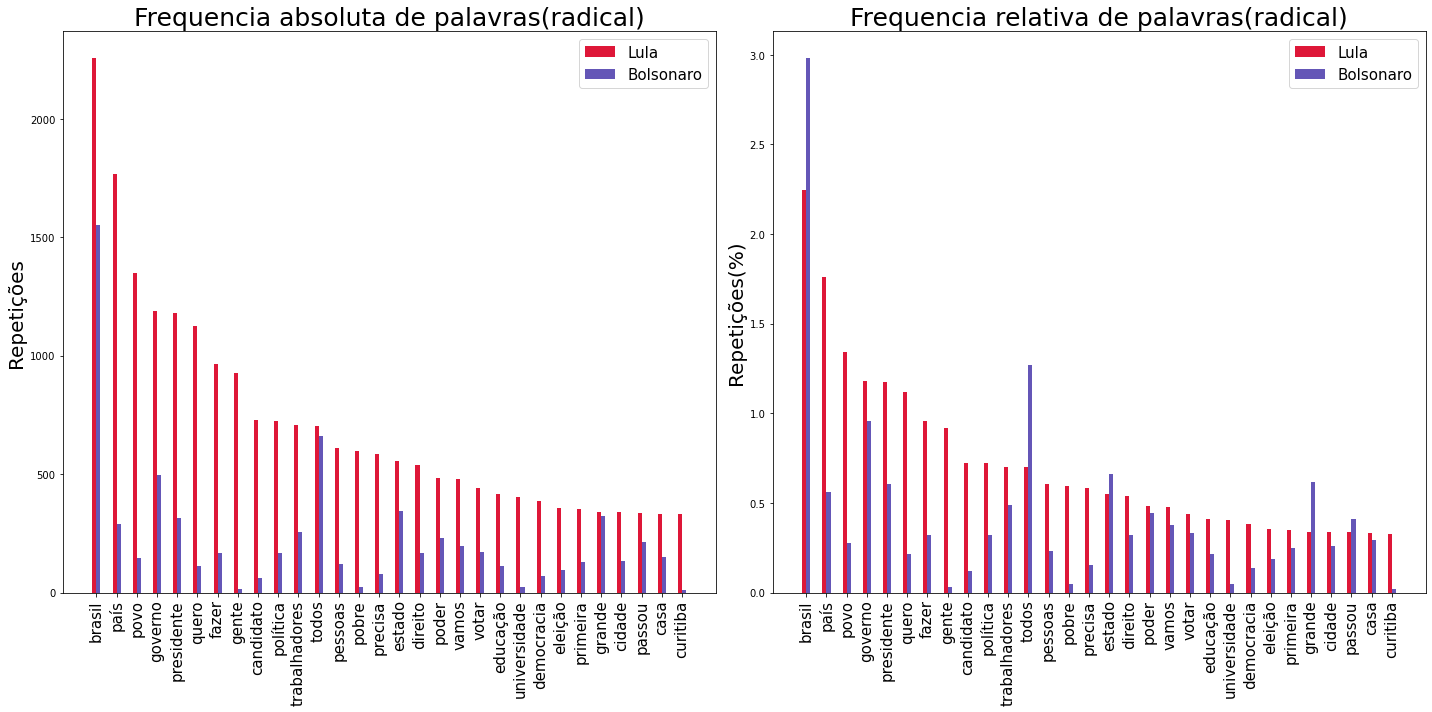

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

radical_df.sort_values(by='count_l', ascending=False, inplace=True)
plot_chart(radical_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(radical_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

plt.tight_layout()
plt.show()

## Perspectiva do Bolsonaro

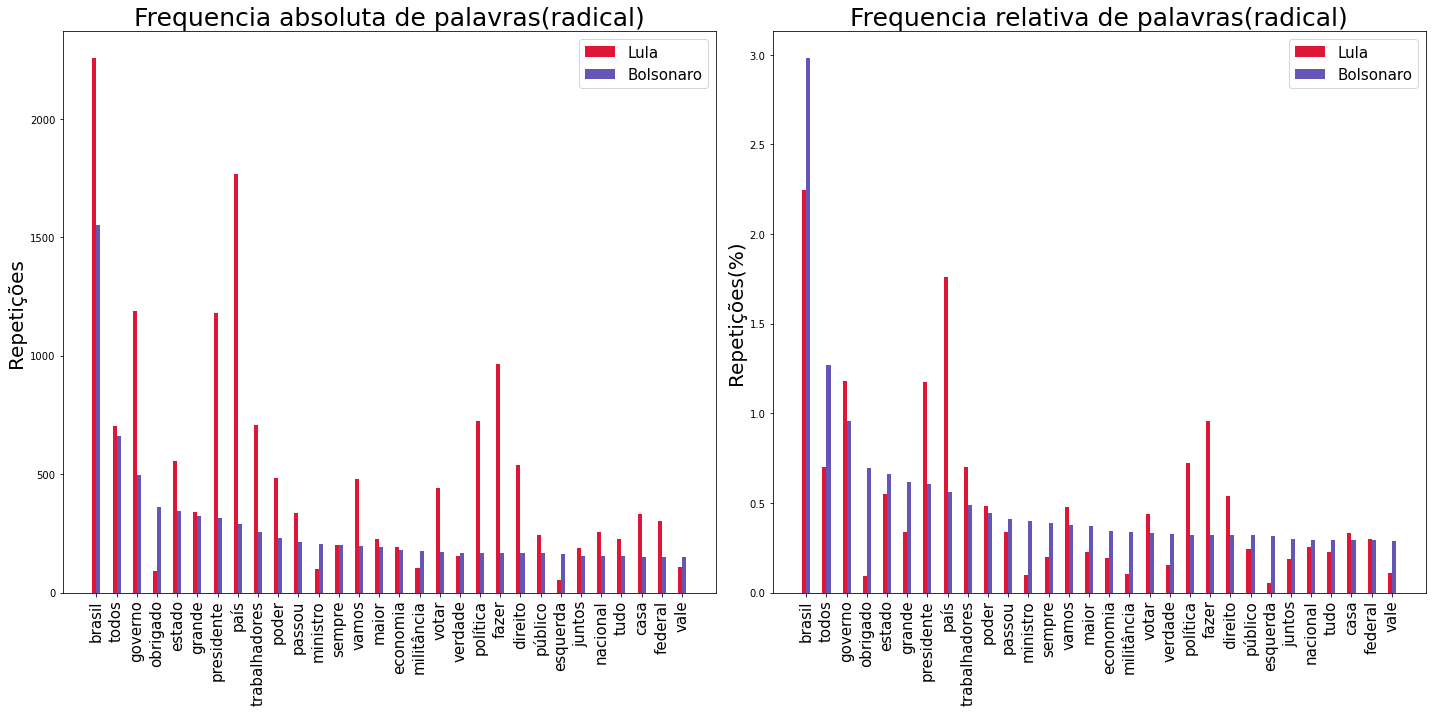

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

radical_df.sort_values(by='count_b', ascending=False, inplace=True)
plot_chart(radical_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(radical_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

plt.tight_layout()
plt.show()

## Palavras chave

### economia

In [20]:
#economia
economia = ['investimento', 'economia', 'agricultura', 'emprego', 'dinheiro', 'mercado', 'trabalhador', 'trabalho', 'desemprego', 'empresas']
lista = [stemmer.stem(x) for x in economia]

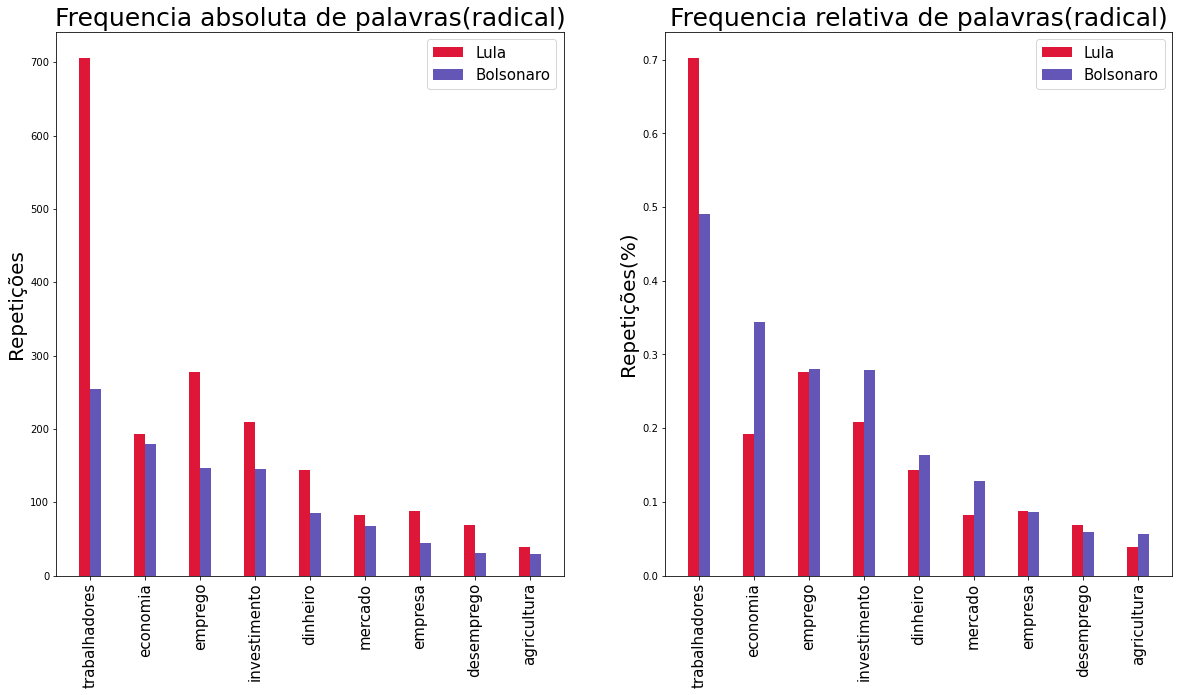

In [21]:
economia_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(economia_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(economia_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### ciência e educação

In [22]:
ciencia = ['educação', 'ciência', 'inovação', 'pesquisa', 'escolas', 'universidade', 'estudar', 'professores']
lista = [stemmer.stem(x) for x in ciencia]

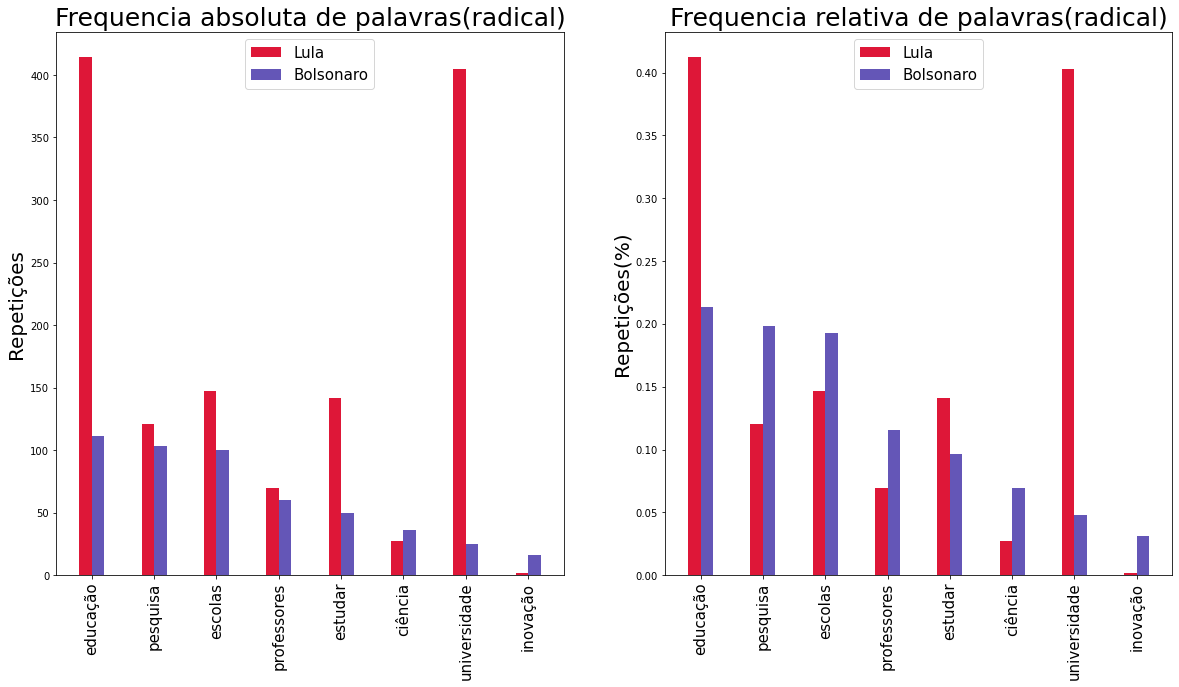

In [23]:
ciencia_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(ciencia_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(ciencia_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### Política

In [24]:
politica = ['bolsafamília', 'ditadura', 'democracia', 'direitos', 'bolsa']
lista = [stemmer.stem(x) for x in politica]

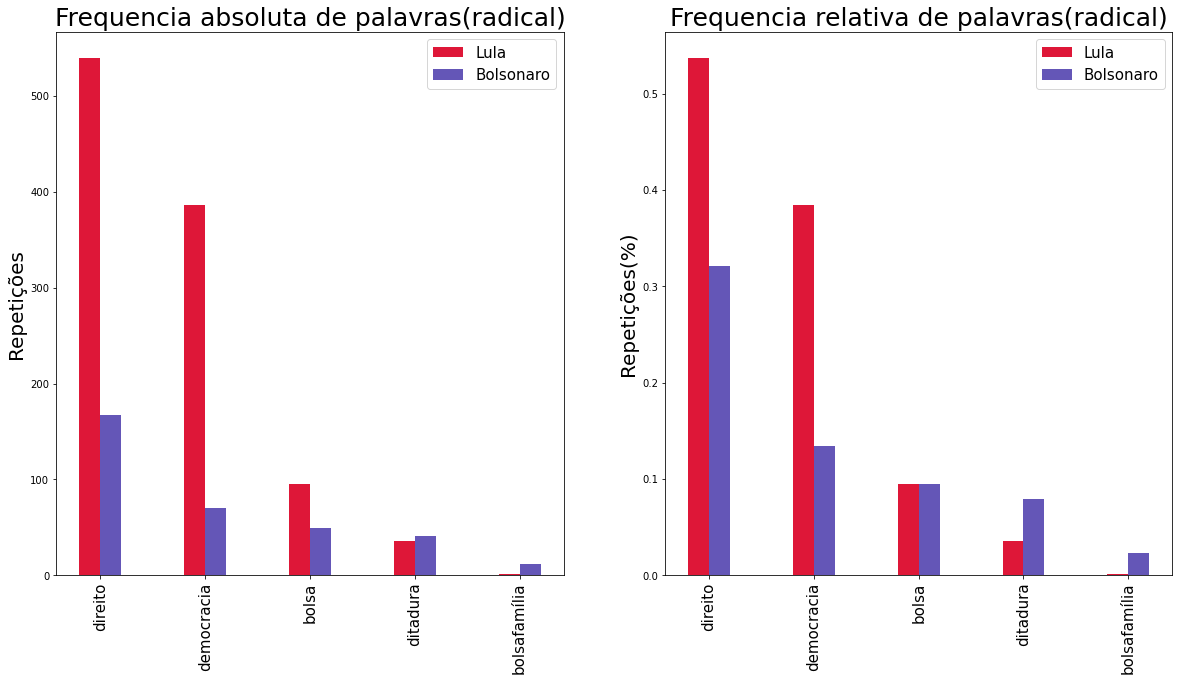

In [25]:
politica_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(politica_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(politica_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### Segurança

In [26]:
seguranca = ['segurança', 'defesa', 'crime']
lista = [stemmer.stem(x) for x in seguranca]

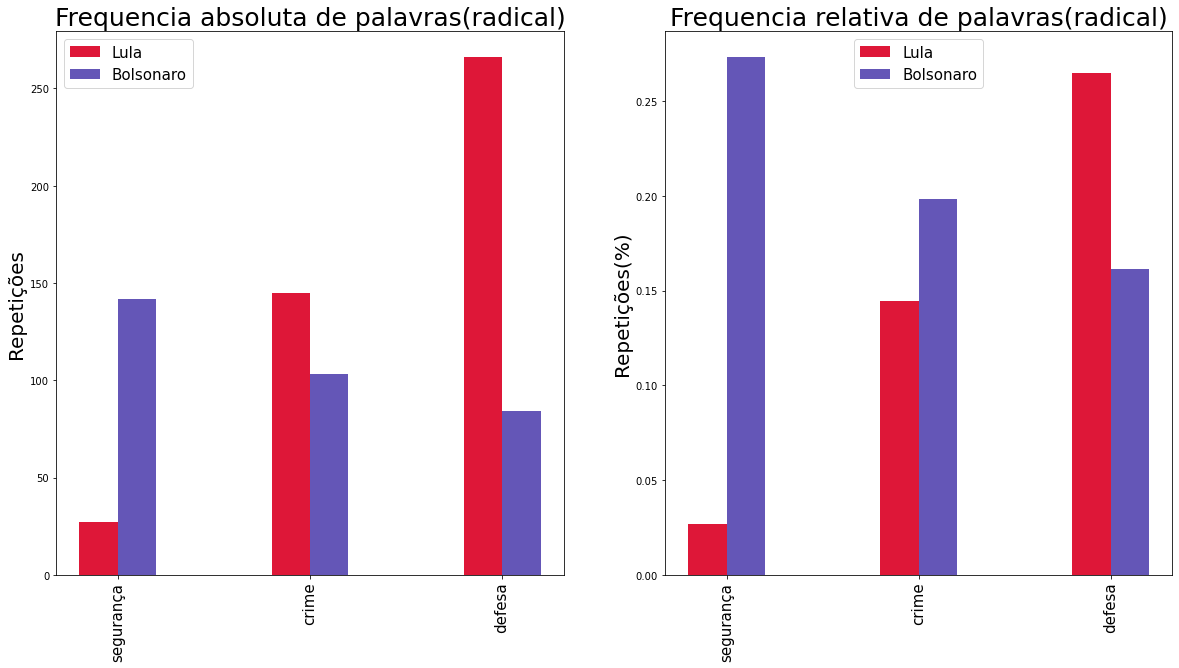

In [27]:
seguranca_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(seguranca_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(seguranca_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### Social

In [28]:
social = ['pobre', 'fome', 'elite', 'sexualidade', 'social', 'liberdade', 'negros']
lista = [stemmer.stem(x) for x in social]

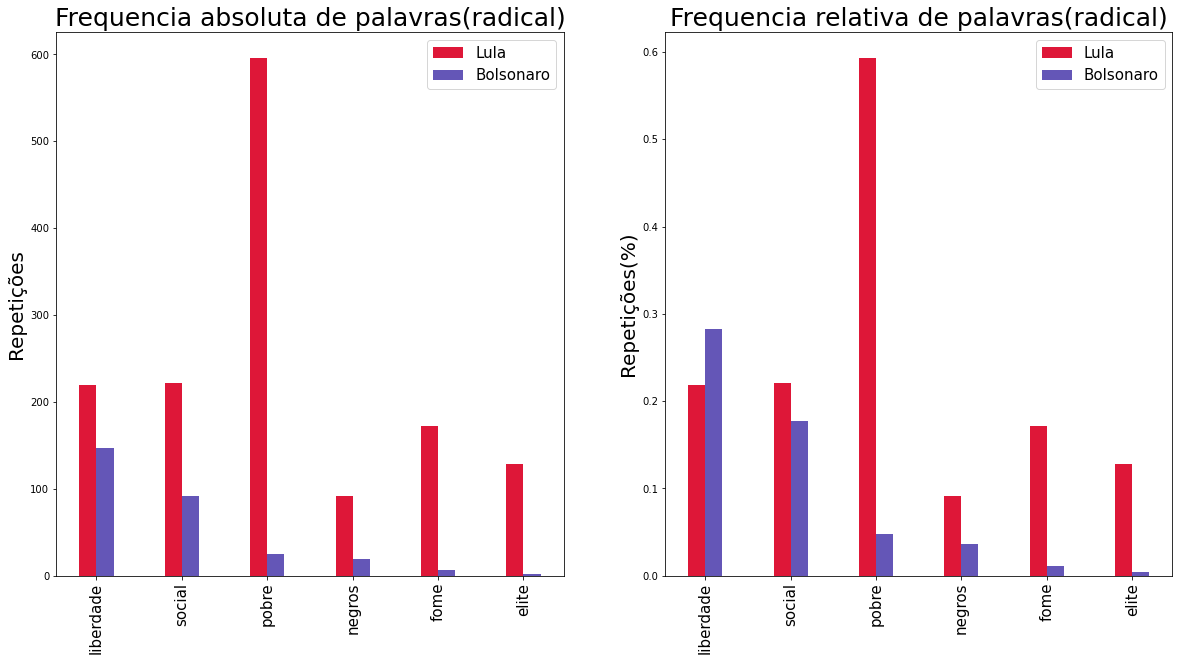

In [29]:
social_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(social_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(social_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### Outros

In [30]:
outros = ['desenvolvimento', 'saúde', 'energia', 'tecnologia']
lista = [stemmer.stem(x) for x in outros]

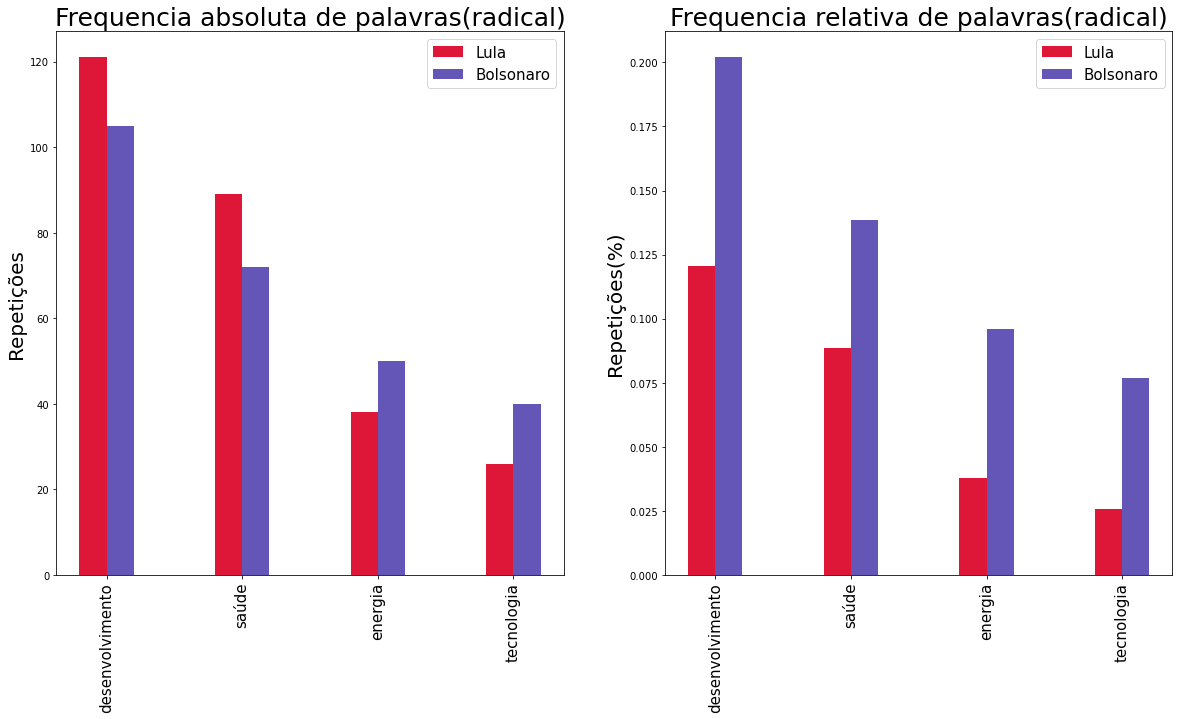

In [31]:
outros_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(outros_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(outros_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')

### Sentimento

In [32]:
sentimento = ["orgulho", 'esperança', 'ódio']
lista = [stemmer.stem(x) for x in sentimento]

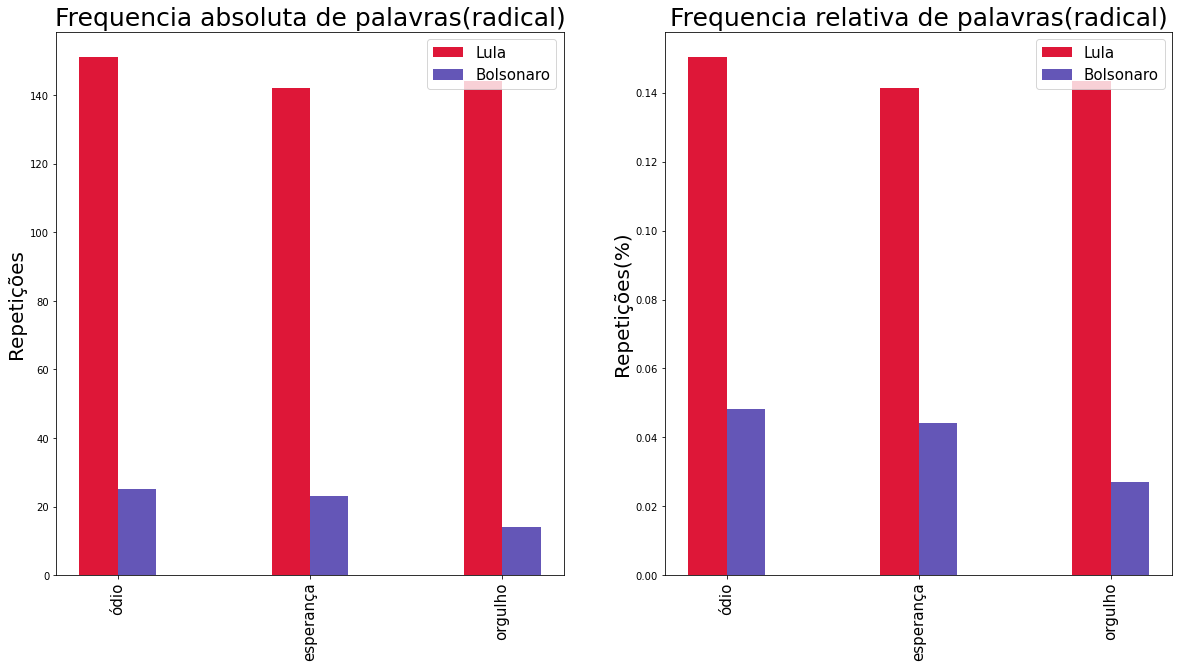

In [33]:
sentimento_df = radical_df.query(f'radical.isin({lista})')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_chart(sentimento_df, column1="count_l", column2="count_b", size=size, ax=ax1, title="Frequencia absoluta de palavras(radical)", ylabel="Repetições", x_labels_col='full')
plot_chart(sentimento_df, column1="count_l_relativo", column2="count_b_relativo", size=size, ax=ax2, title="Frequencia relativa de palavras(radical)", ylabel="Repetições(%)", x_labels_col='full')